In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
credit = pd.read_csv('../data/credit_applications.csv')
customers = pd.read_csv('../data/customers.csv')
df = pd.merge(credit, customers, on=['client_nr', 'yearmonth'], how='outer')  # You can change 'outer' to 'inner', 'left', or 'right' as needed


In [21]:
df['number_rows'] = df.groupby('client_nr')['client_nr'].transform('count') 

In [22]:
#correlation with number_rows with credit_application
df['number_rows'].corr(df['credit_application'])

0.022049852169697945

In [3]:
df.columns

Index(['Unnamed: 0_x', 'client_nr', 'yearmonth', 'credit_application',
       'nr_credit_applications', 'Unnamed: 0_y', 'total_nr_trx',
       'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx',
       'volume_credit_trx', 'min_balance', 'max_balance', 'CRG'],
      dtype='object')

In [3]:
df.drop(columns=['Unnamed: 0_y',  'Unnamed: 0_x'], inplace=True)

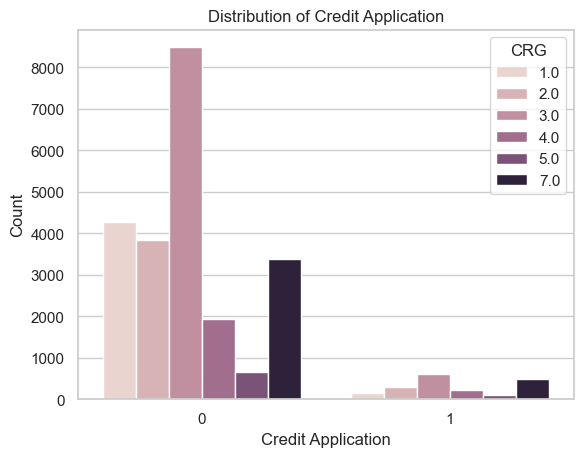

In [18]:
sns.set(style="whitegrid")
# Plot the distribution of the target variable
sns.countplot(data=df, x='credit_application', hue = 'CRG')
plt.title('Distribution of Credit Application')
plt.xlabel('Credit Application')
plt.ylabel('Count')
plt.show()


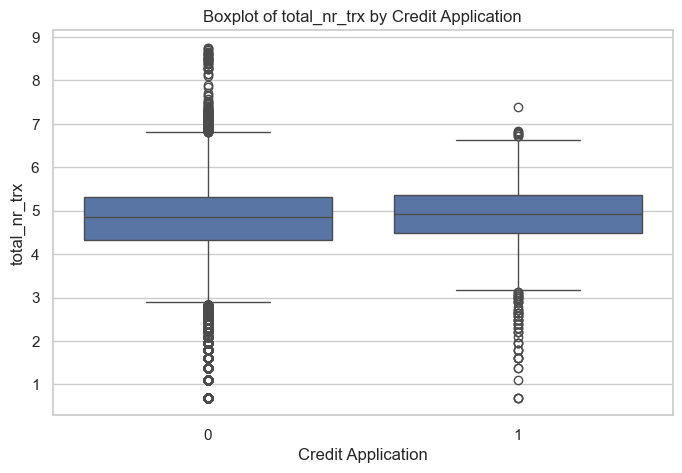

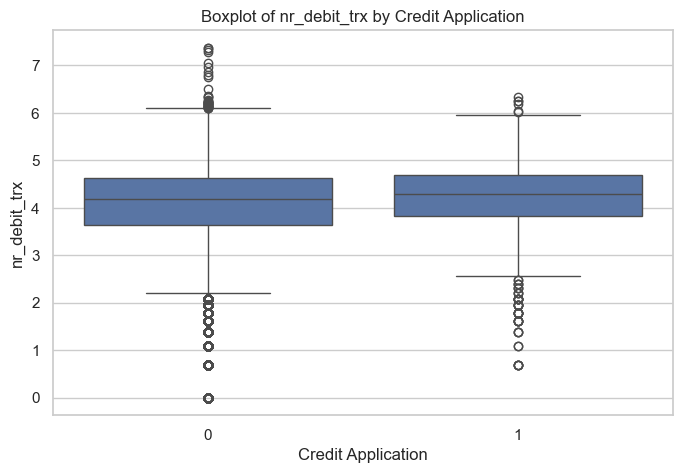

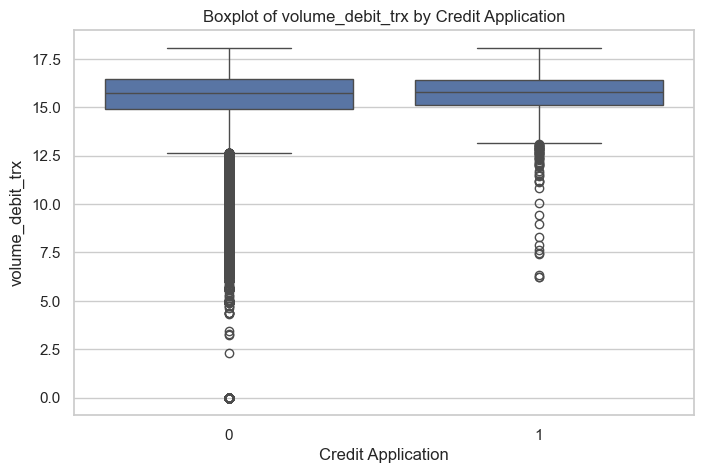

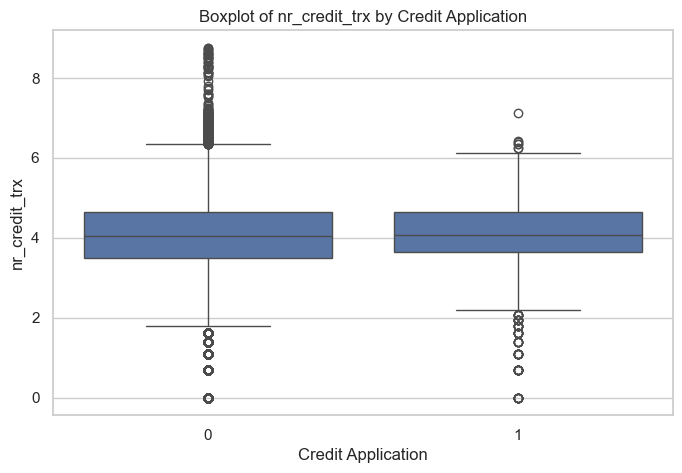

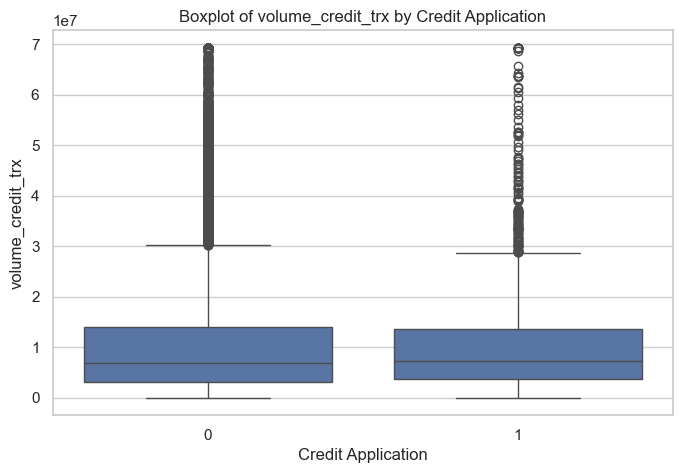

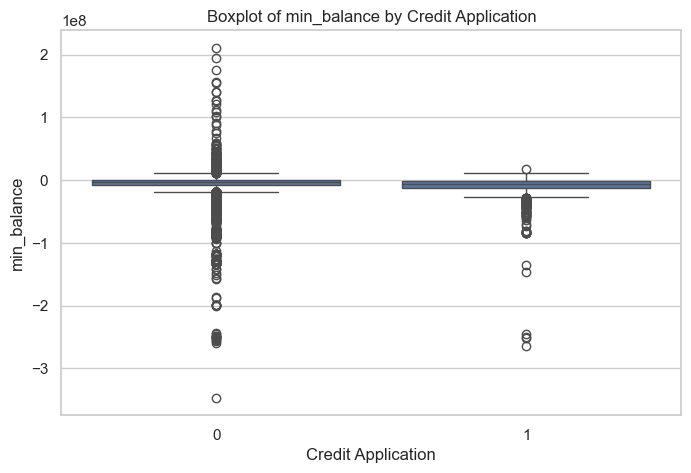

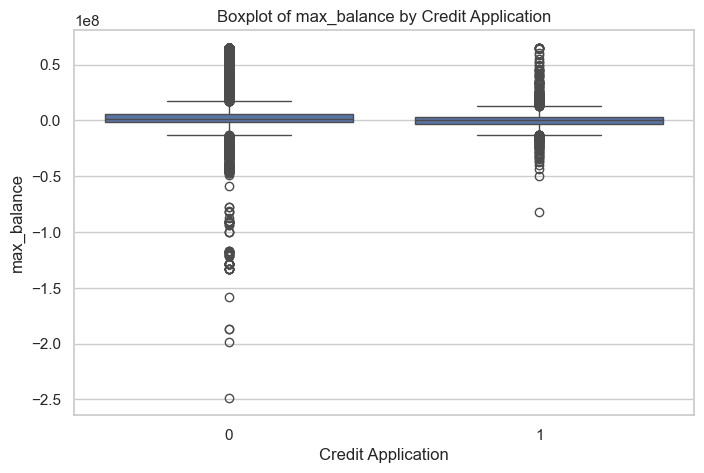

In [74]:
# Continuous variables to compare
continuous_vars = ['total_nr_trx', 'nr_debit_trx', 'volume_debit_trx', 
                   'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance']

for var in continuous_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='credit_application', y=var)
    plt.title(f'Boxplot of {var} by Credit Application')
    plt.xlabel('Credit Application')
    plt.ylabel(var)
    plt.show()


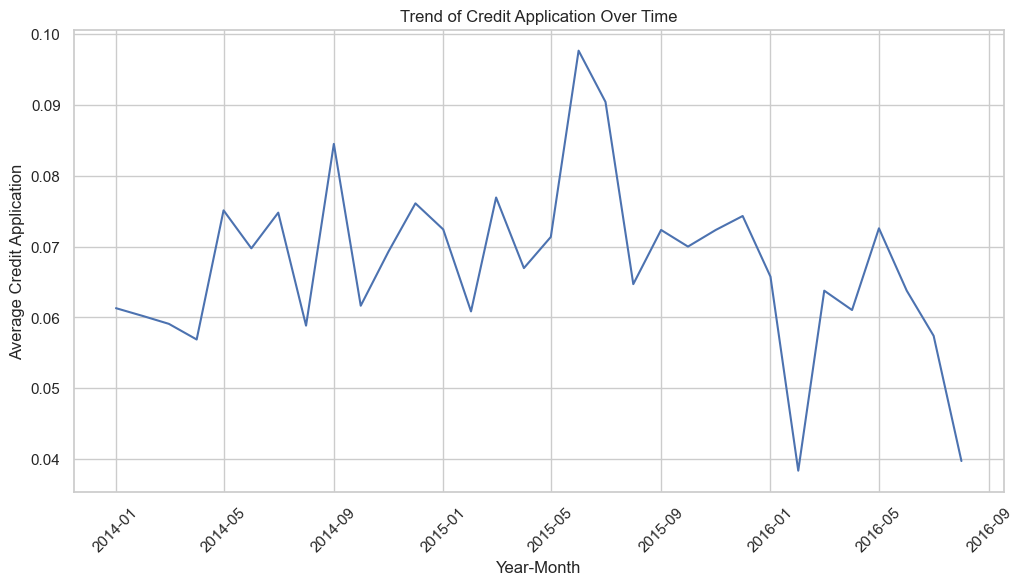

In [75]:
df['yearmonth'] = pd.to_datetime(df['yearmonth'], format='%Y%m')
monthly_avg = df.groupby('yearmonth')['credit_application'].mean().reset_index()

# Plot trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='yearmonth', y='credit_application')
plt.title('Trend of Credit Application Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Credit Application')
plt.xticks(rotation=45)
plt.show()


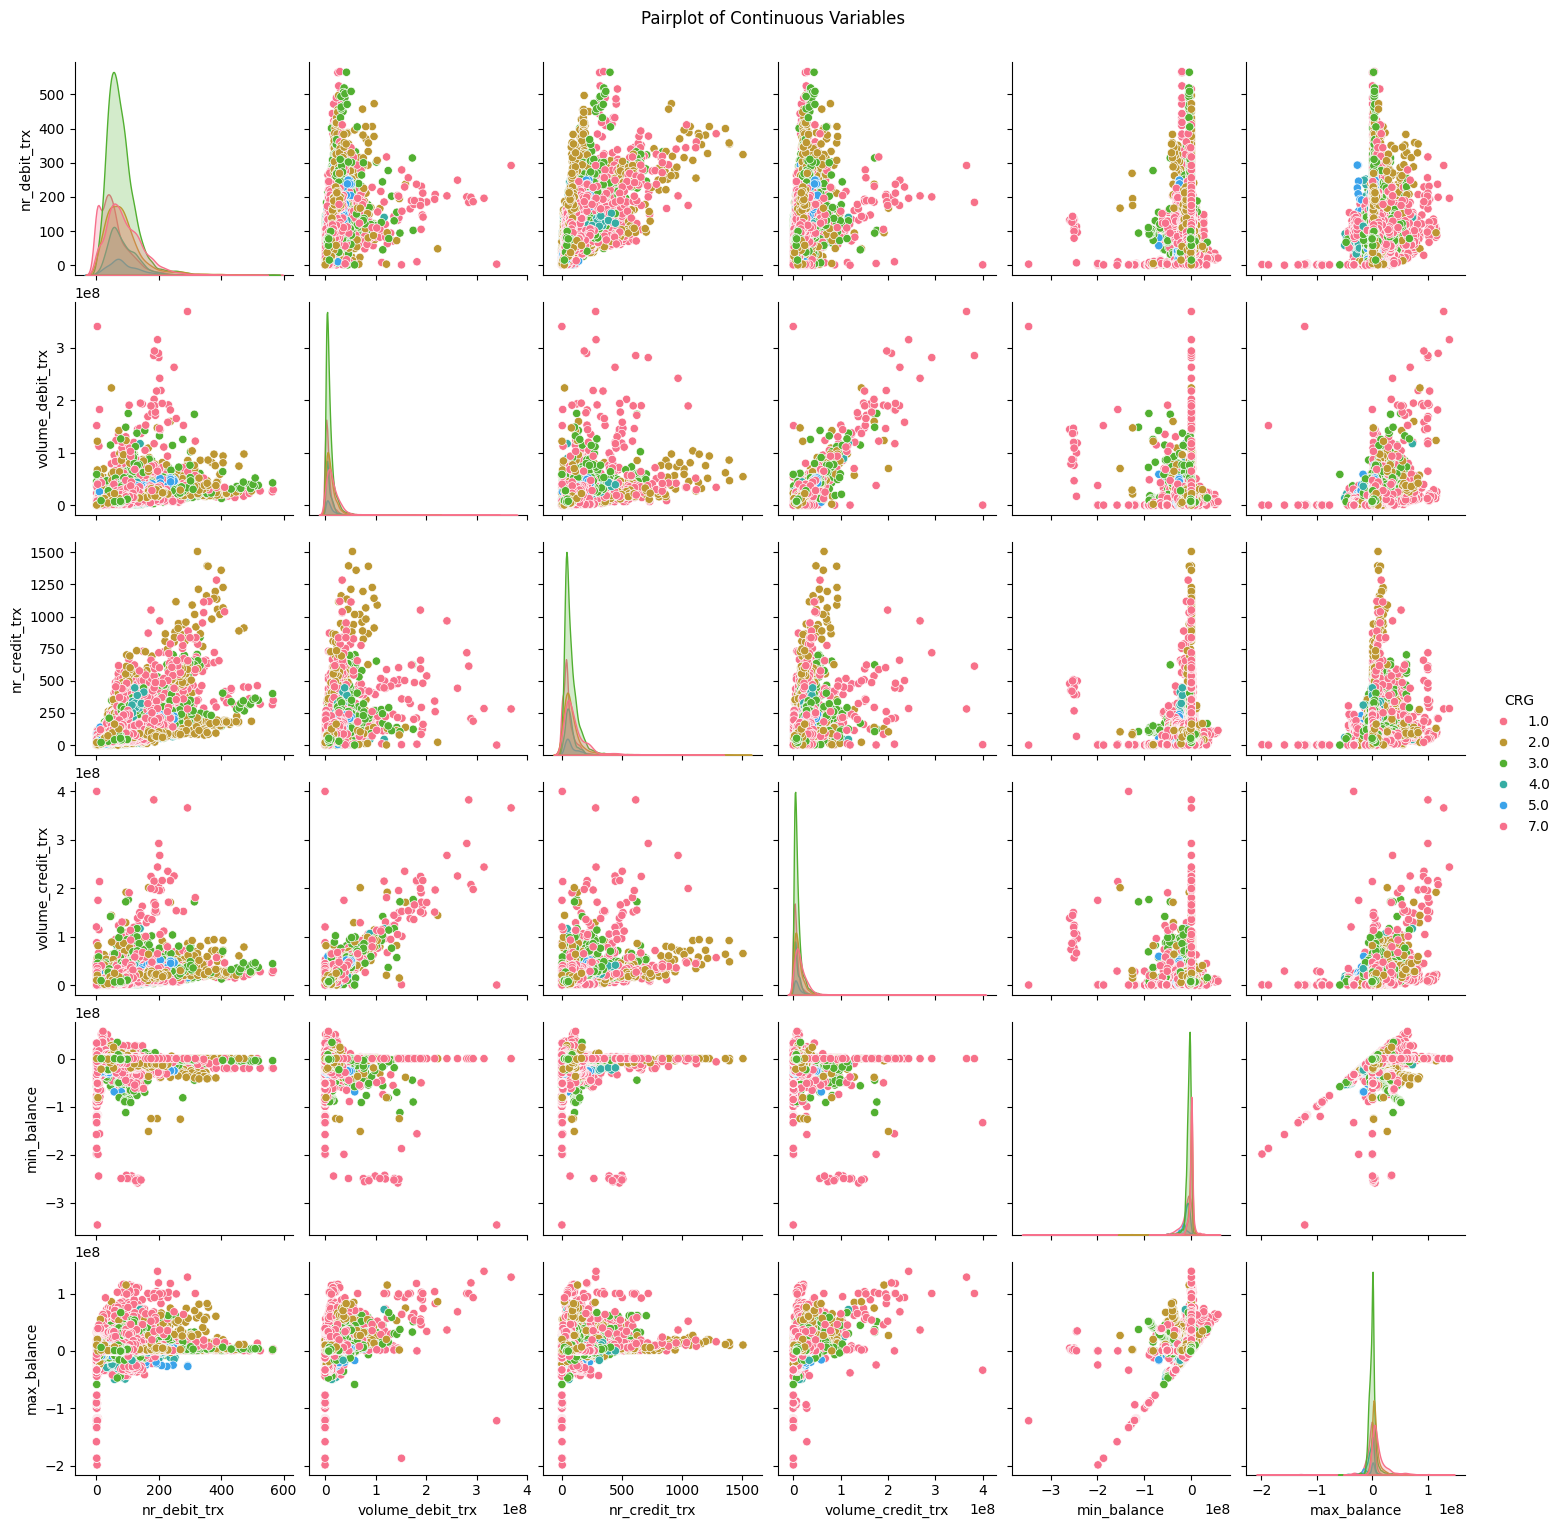

In [17]:
# Pair plot for a subset of continuous variables with hue set to the target variable
continuous_vars = [ 'nr_debit_trx', 'volume_debit_trx', 
                   'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance']

sns.pairplot(df, vars=continuous_vars, hue='CRG', diag_kind='kde', palette="husl")
plt.suptitle('Pairplot of Continuous Variables', y=1.02)
plt.show()


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_35430/1452512771.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', ncol=2, fontsize=8)


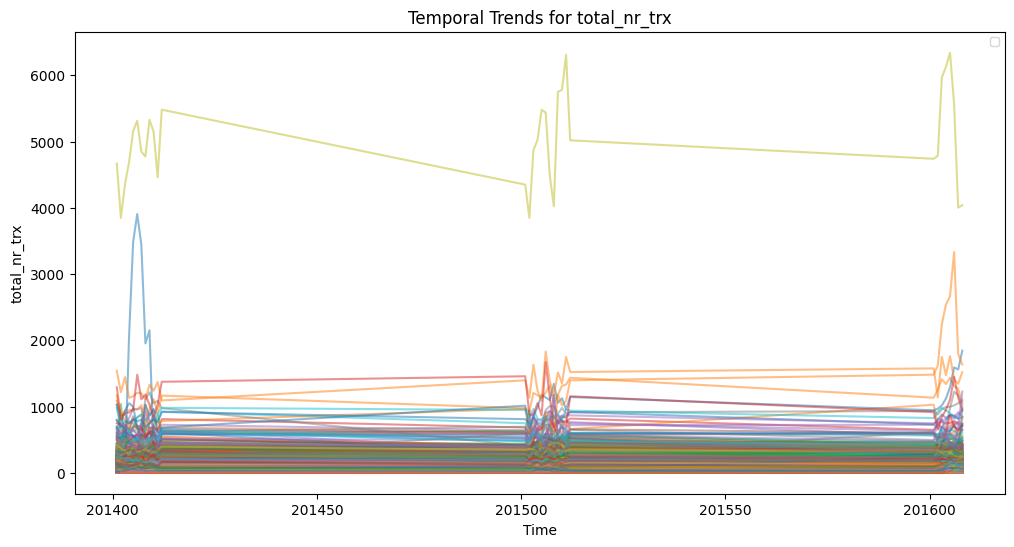

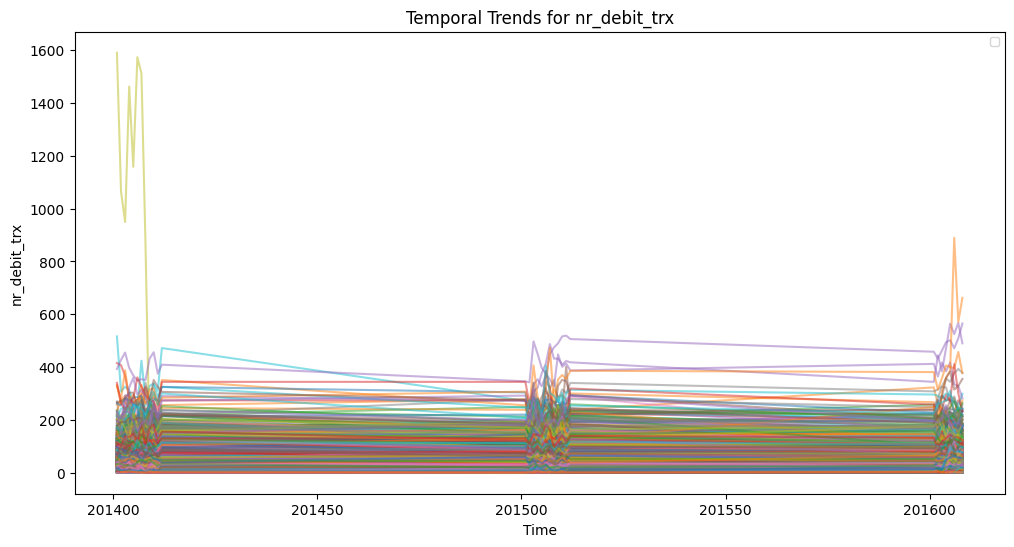

In [6]:
import matplotlib.pyplot as plt

# Select a feature to visualize over time
selected_features = ['total_nr_trx', 'nr_debit_trx']

for feature in selected_features:
    plt.figure(figsize=(12, 6))
    for client_id, group_data in df.groupby('client_nr'):  # Assuming 'client_id' identifies clients
        plt.plot(group_data['yearmonth'], group_data[feature], alpha=0.5)
    plt.title(f'Temporal Trends for {feature}')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend(loc='upper right', ncol=2, fontsize=8)
    plt.show()


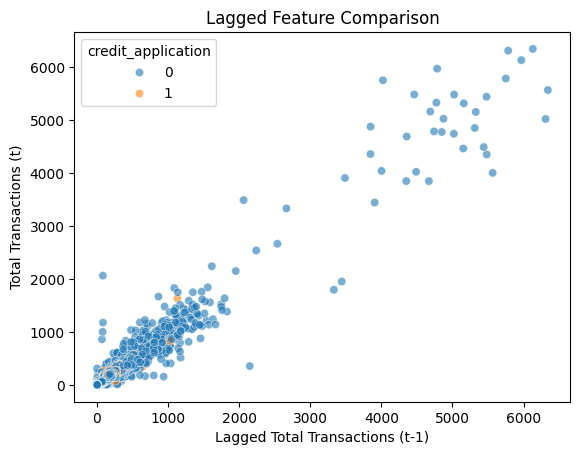

In [8]:
import seaborn as sns

# Compute lagged features
df['total_nr_trx_lag1'] = df.groupby('client_nr')['total_nr_trx'].shift(1)

# Scatter plot to compare lagged feature with current value
sns.scatterplot(data=df, x='total_nr_trx_lag1', y='total_nr_trx', hue='credit_application', alpha=0.6)
plt.title('Lagged Feature Comparison')
plt.xlabel('Lagged Total Transactions (t-1)')
plt.ylabel('Total Transactions (t)')
plt.show()


In [15]:
df.CRG.value_counts()

CRG
3.0    9097
1.0    4424
2.0    4141
7.0    3858
4.0    2161
5.0     778
Name: count, dtype: int64

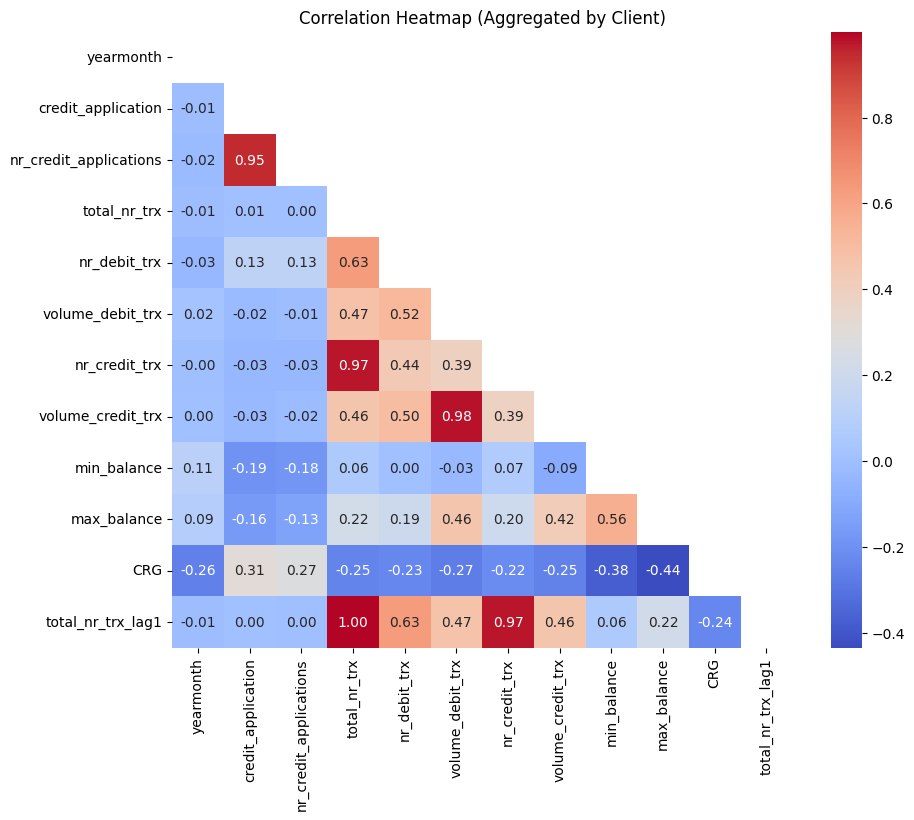

In [9]:
import numpy as np

# Aggregate data at client level (mean aggregation as an example)
agg_df = df.groupby('client_nr').mean()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = agg_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(corr_matrix))
plt.title('Correlation Heatmap (Aggregated by Client)')
plt.show()


In [4]:
# Get unique customer numbers where 'credit_application' is 1
customer_applied = df[df['credit_application'] == 1]['client_nr'].unique()

# Filter the DataFrame based on the unique customer numbers
df_applied = df[df['client_nr'].isin(customer_applied)]


customer_not_applied = df[df['credit_application'] == 0]['client_nr'].unique()  
df_not_applied = df[df['client_nr'].isin(customer_not_applied)]


In [4]:
df['year'] = df['yearmonth'] // 100
df['month'] = df['yearmonth'] % 100


In [5]:
for col in ['total_nr_trx', 'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx']:
    df[col] = np.log1p(df[col])  # Use log(1+x) to avoid log(0)

for col in ['volume_debit_trx', 'volume_credit_trx', 'max_balance']:
    df[col] = df[col].clip(upper=df[col].quantile(0.99))


df.transaction_balance_ratio = df.total_nr_trx / df.max_balance
df.debit_credit_ratio = df.nr_debit_trx / df.nr_credit_trx

# Create a binary flag for negative balances
df['min_balance_negative_flag'] = (df['min_balance'] < 0).astype(int)

# Take the absolute value for transformation
df['min_balance_abs'] = df['min_balance'].abs()

# Apply log1p transformation to the absolute value
df['min_balance_abs'] = np.log1p(df['min_balance_abs'])


# Create a binary flag for negative balances
df['max_balance_negative_flag'] = (df['max_balance'] < 0).astype(int)

# Take the absolute value for transformation
df['max_balance_abs'] = df['max_balance'].abs()

# Apply log1p transformation to the absolute value
df['max_balance_abs'] = np.log1p(df['max_balance_abs'])


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/550620337.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.transaction_balance_ratio = df.total_nr_trx / df.max_balance
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/550620337.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.debit_credit_ratio = df.nr_debit_trx / df.nr_credit_trx


In [7]:
# Interaction Features with CRG
df['CRG_total_nr_trx'] = df['CRG'] * df['total_nr_trx']
df['CRG_nr_debit_trx'] = df['CRG'] * df['nr_debit_trx']
df['CRG_nr_credit_trx'] = df['CRG'] * df['nr_credit_trx']
df['CRG_volume_debit_trx'] = df['CRG'] * df['volume_debit_trx']
df['CRG_volume_credit_trx'] = df['CRG'] * df['volume_credit_trx']

# Binning CRG into categories (example: quartiles)

labels = ['Low', 'Medium-Low', 'Medium-High', 'High']  
df['CRG_binned'] = pd.qcut(
    df['CRG'], 
    q=5,  
    labels=labels[:4],  
    duplicates='drop' 
)


df = pd.get_dummies(df, columns=['CRG_binned'], drop_first=False)


In [8]:
def create_features(data, group_col, time_col, rolling_features, cumulative_features, window=3):
    """
    Creates rolling window features, recency, and cumulative features for the dataset.

    Args:
    - data (DataFrame): Input dataset.
    - group_col (str): Column for grouping (e.g., client_nr).
    - time_col (str): Column representing time (e.g., yearmonth).
    - rolling_features (list): List of features to compute rolling statistics.
    - cumulative_features (list): List of features to compute cumulative sums.
    - window (int): Size of the rolling window.

    Returns:
    - DataFrame with new rolling, recency, and cumulative features.
    """
    data = data.copy()

    data = data.sort_values(by=[group_col, time_col])

    # Rolling window features
    for feature in rolling_features:
        data[f'{feature}_rolling_mean_{window}'] = data.groupby(group_col)[feature].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        data[f'{feature}_rolling_std_{window}'] = data.groupby(group_col)[feature].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        data[f'{feature}_rolling_sum_{window}'] = data.groupby(group_col)[feature].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        )

    # Recency feature: Check if there was a credit application in the past 6 months (excluding the current month)
    def calculate_past_6_months_flag_excluding_current(x):
        return x.shift().rolling(window=6, min_periods=1).max()

    data['recency_6_months'] = data.groupby(group_col)['credit_application'].transform(
        calculate_past_6_months_flag_excluding_current
    )

    # Number of credit applications in the past 6 months (excluding the current month)
    def calculate_past_6_months_count_excluding_current(x):
        return x.shift().rolling(window=6, min_periods=1).sum()

    data['nr_applications_6_months'] = data.groupby(group_col)['nr_credit_applications'].transform(
        calculate_past_6_months_count_excluding_current
    )

    # Handle missing values with backward fill and median replacement
    data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))
    data.fillna(data.median(), inplace=True)
    data.reset_index(drop=True, inplace=True)

    return data

rolling_features = ['nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'min_balance',
                    'max_balance', 'CRG', 'total_nr_trx']
cumulative_features = ['nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'total_nr_trx']

processed_data = create_features(
    data=df,
    group_col='client_nr',
    time_col='yearmonth',
    rolling_features=rolling_features,
    cumulative_features=cumulative_features,
    window=3
)



/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/2161067413.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/2161067413.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))


In [9]:
processed_data[processed_data.client_nr == 974]

,client_nr,yearmonth,credit_application,nr_credit_applications,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,...,max_balance_rolling_std_3,max_balance_rolling_sum_3,CRG_rolling_mean_3,CRG_rolling_std_3,CRG_rolling_sum_3,total_nr_trx_rolling_mean_3,total_nr_trx_rolling_std_3,total_nr_trx_rolling_sum_3,recency_6_months,nr_applications_6_months
29572,974,201401,0,0,0.693147,0.000000,0.000000,0.693147,872982.00,-248520614,...,1.757306e+08,-248520614.0,3.0,0.0,3.0,0.693147,0.286707,0.693147,0.0,0.0
29573,974,201407,0,0,1.098612,0.000000,0.000000,1.098612,69286522.15,-248031918,...,1.757306e+08,-248520614.0,3.0,0.0,6.0,0.895880,0.286707,1.791759,0.0,0.0
29574,974,201411,0,0,0.693147,0.000000,0.000000,0.693147,2500.00,2500,...,1.434842e+08,-248518114.0,3.0,0.0,9.0,0.828302,0.234095,2.484907,0.0,0.0
29575,974,201507,0,0,0.693147,0.693147,7.824446,0.000000,0.00,0,...,1.443376e+03,2500.0,3.0,0.0,9.0,0.828302,0.234095,2.484907,0.0,0.0


In [10]:
def add_lagged_and_statistical_features(data, group_col, features):
    """
    Adds lagged features (1 to 6 months) and min, max, mean, and std for the last 2 to 6 months.

    Args:
    - data (DataFrame): Input dataset.
    - group_col (str): Column for grouping (e.g., client_nr).
    - features (list): List of features to generate lagged and statistical features.

    Returns:
    - DataFrame with lagged and statistical features added.
    """
    data = data.copy()

    # Lagged features from 1 to 6 months
    for lag in range(1, 7):
        for feature in features:
            data[f'{feature}_lag_{lag}'] = data.groupby(group_col)[feature].shift(lag)

    # Min, Max, Mean, and Std for the previous 2, 3, 4, 5, 6 months
    for window_size in range(2, 7):
        for feature in features:
            data[f'{feature}_min_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).min()
            )
            data[f'{feature}_max_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).max()
            )
            data[f'{feature}_mean_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).mean()
            )
            data[f'{feature}_std_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).std()
            )

    # Handle missing values with backward fill and median replacement
    data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))
    data.fillna(data.median(), inplace=True)
    data.reset_index(drop=True, inplace=True)

    return data

features = ['nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'min_balance',
            'max_balance', 'CRG', 'total_nr_trx', 'min_balance', 'max_balance', 'nr_credit_applications']

processed_data = add_lagged_and_statistical_features(
    data=processed_data,
    group_col='client_nr',
    features=features
)


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/3652949445.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{feature}_std_last_{window_size}'] = data.groupby(group_col)[feature].transform(
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/3652949445.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{feature}_min_last_{window_size}'] = data.groupby(group_col)[feature].transform(
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_17798/3652949445.py:26: PerformanceWarnin

In [14]:
processed_data.shape

(29996, 103)

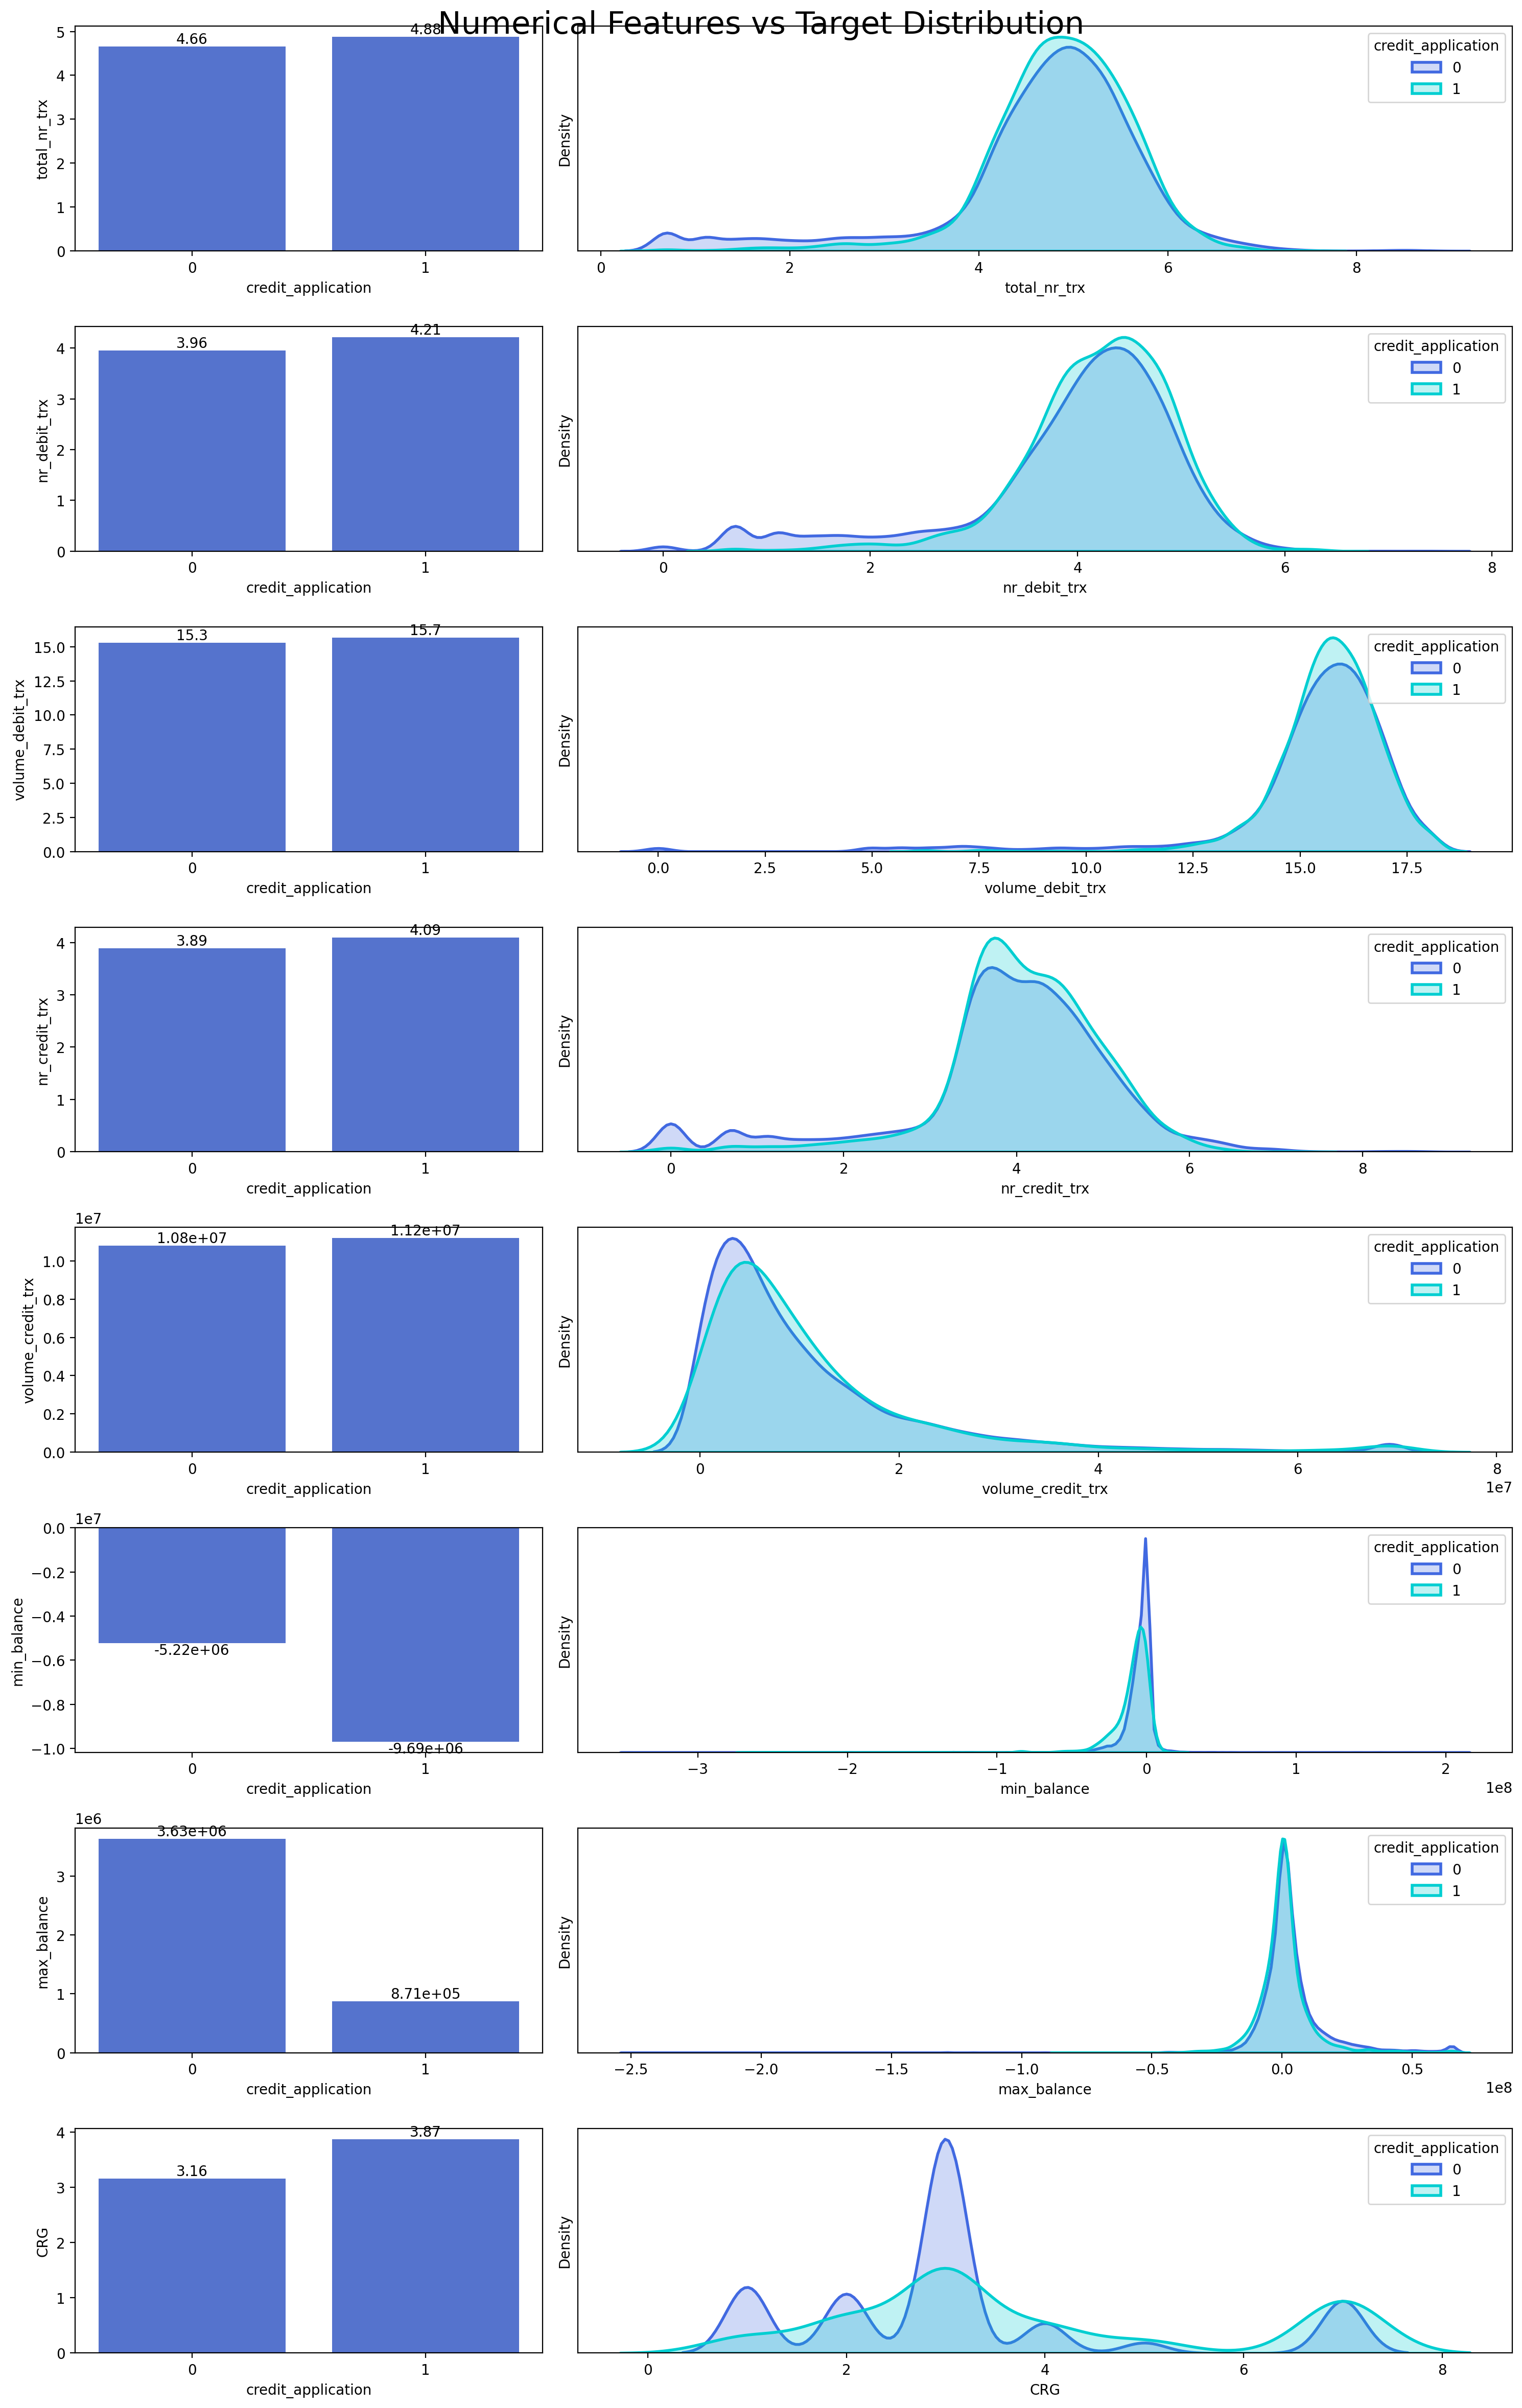

In [85]:
# Specify the numerical features to analyze
Num_Features = [
    'total_nr_trx', 'nr_debit_trx', 'volume_debit_trx',
    'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance', 'CRG',
   
]

Target = 'credit_application'  

# Set the seaborn palette
sns.set_palette(['royalblue', 'darkturquoise'])

# Create subplots
fig, ax = plt.subplots(len(Num_Features), 2, figsize=(15, len(Num_Features) * 3), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i, col in enumerate(Num_Features):
    # Barplot for numerical features against the target
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i, 0], errorbar=None)
    
    # KDE plot for numerical feature distributions grouped by target
    sns.kdeplot(data=df[df[Target] == 0], x=col, fill=True, linewidth=2, ax=ax[i, 1], label='0')
    sns.kdeplot(data=df[df[Target] == 1], x=col, fill=True, linewidth=2, ax=ax[i, 1], label='1')
    
    # Clean up the right-hand plot
    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title=Target, loc='upper right')
    
    # Add bar sizes to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='%.3g')

plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

In [46]:
df.isna().sum().sum()

5537

In [11]:
processed_data.drop(columns=['nr_credit_applications', 'total_nr_trx'], inplace=True)

In [11]:
df.drop(columns=['nr_credit_applications'], inplace=True)

In [25]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Sample DataFrame
df2 = processed_data.copy()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
df2["outlier_label"] = iso_forest.fit_predict(df2.drop(columns=["credit_application"]))

# Add a label column: -1 for outliers, 1 for normal points
df2["outlier_label"] = iso_forest.fit_predict(df2.drop(columns=["credit_application"]))

outlier_clients = df2[df2["outlier_label"] == -1]["client_nr"].unique()

filtered_df = df2[df2["client_nr"].isin(outlier_clients)]
normal_clients = df2[df2["outlier_label"] == 1]["client_nr"].unique()
filtered_df_normal = df2[df2["client_nr"].isin(normal_clients)]



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from lightgbm import LGBMClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler


# Determine which clients have at least one credit_application = 1
clients_with_positive = processed_data[processed_data['credit_application'] == 1]['client_nr'].unique()
clients_without_positive = list(set(processed_data['client_nr']) - set(clients_with_positive))

# Stratified splitting of clients
train_clients_positive, test_clients_positive = train_test_split(
    clients_with_positive, test_size=0.2, random_state=42
)
train_clients_negative, test_clients_negative = train_test_split(
    clients_without_positive, test_size=0.2, random_state=42
)

# Combine stratified splits for train and test
train_clients = list(train_clients_positive) + list(train_clients_negative)
test_clients = list(test_clients_positive) + list(test_clients_negative)

# Split the data into train and test sets
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]

# Debugging: Check the ratio of clients with positive cases in train and test
train_positive_ratio = len(train_data[train_data['credit_application'] == 1]) / len(train_data)
test_positive_ratio = len(test_data[test_data['credit_application'] == 1]) / len(test_data)

print(f"Train positive ratio: {train_positive_ratio:.2%}")
print(f"Test positive ratio: {test_positive_ratio:.2%}")

# Prepare X and y for training and testing
X_train = train_data.drop(columns=['client_nr', 'yearmonth', 'credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['client_nr', 'yearmonth', 'credit_application'])
y_test = test_data['credit_application']


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#model = EasyEnsembleClassifier(random_state=42, n_estimators=10)


# Define class weights
class_weights = {0: 1, 1: 20} 

# Create a base estimator with class weights
base_estimator = DecisionTreeClassifier(max_depth=3, class_weight=class_weights)


# Define models and parameter grids for comparison
models = {
    #"Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    #"XGBoost": XGBClassifier(random_state=42, scale_pos_weight=50, n_jobs=-1),
    # "AdaBoost": AdaBoostClassifier(random_state=42, base_estimator=base_estimator),
    # "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced",  n_jobs=-1),
    #"GradientBoosting": GradientBoostingClassifier(random_state=42),
    #"BalancedRandomForest": BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    "hist_gradient_boosting": HistGradientBoostingClassifier(random_state=42, max_iter=100, class_weight = 'balanced')
}

param_grids = {
    # "Random Forest": {
    #     'n_estimators': [100, 300],
    #     'max_depth': [5, 10, 15],
    #     'min_samples_split': [2, 5, 10],
    # },
    # "XGBoost": {
    #     'n_estimators': [300],
    #     'learning_rate': [0.1, 0.2],
    #     'max_depth': [ 15],
    #     'alpha': [ 5, 10],
    # },
    # "AdaBoost": {
    #     'n_estimators': [ 50],
    #     'learning_rate': [ 0.5, 1.0],
    # },
    # "LightGBM": {
    #     'n_estimators': [ 500],
    #     'learning_rate': [0.01],
    #     'max_depth': [ 50],
    #     'lambda_l1': [5],
    #     'min_child_weight': [1],
    #     'boosting_type': ['dart'],
    # },
    # "BalancedRandomForest": {
    #     'n_estimators': [500],  
    #     'max_depth': [20],      
    #     'max_features': ['sqrt', 'log2'], 
    #     #'class_weight': [{0: 1, 1: 14}],  
    # },
    "hist_gradient_boosting": {
        'max_depth': [10, 20],
        'learning_rate': [0.1, 0.2],
        'l2_regularization': [1, 10],
    }
}

# Perform Grid Search with Cross Validation for each model
best_models = {}
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\nStarting Grid Search for {model_name}")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='f1',
        cv=stratified_kfold,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 Score for {model_name}: {grid_search.best_score_}")

# Evaluate all best models on the test set
for model_name, best_model in best_models.items():
    print(f"\nEvaluating {model_name}")
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    y_pred = best_model.predict(X_test)
    precision = precision_score(y_test, y_pred, zero_division=1)
    print(f"{model_name} Test AUC: {auc}")
    print(f"{model_name} Test Precision: {precision}")


Train positive ratio: 6.68%
Test positive ratio: 7.05%

Starting Grid Search for hist_gradient_boosting
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for hist_gradient_boosting: {'l2_regularization': 10, 'learning_rate': 0.1, 'max_depth': 20}
Best F1 Score for hist_gradient_boosting: 0.23732794820149952

Evaluating hist_gradient_boosting
hist_gradient_boosting Test AUC: 0.7505456837120971
hist_gradient_boosting Test Precision: 0.14431934493346982


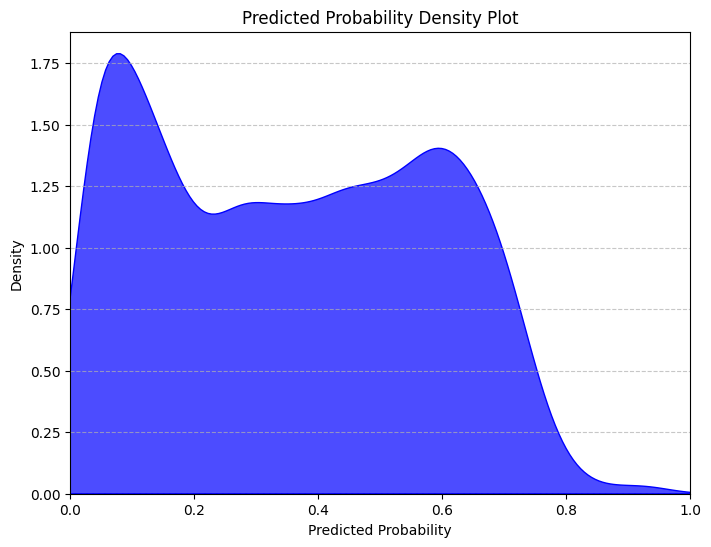

In [14]:
import seaborn as sns

model = best_models['hist_gradient_boosting']
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Plot density of predicted probabilities
plt.figure(figsize=(8, 6))
sns.kdeplot(y_pred_proba, fill=True, color='blue', alpha=0.7)
plt.title('Predicted Probability Density Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [110]:
print(model)

LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 20}, lambda_l1=5,
               learning_rate=0.01, max_depth=50, min_child_weight=1,
               n_estimators=500, n_jobs=-1, random_state=42)


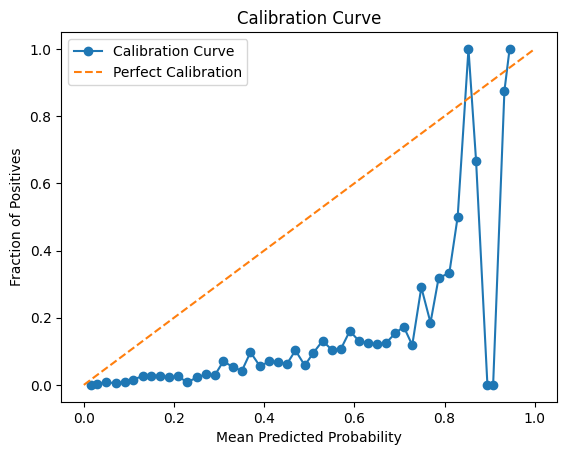

In [15]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=50)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()


In [18]:
# Adjust the prediction threshold
from sklearn.metrics import classification_report, accuracy_score
threshold = 0.5 # You can change this value if needed
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_pred = (y_pred_proba > threshold).astype(int)

# Print the number of positive predictions

# Evaluate the model
print(classification_report(y_test, y_pred))

# Evaluate the model acuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.70      0.81      5565
           1       0.14      0.67      0.24       422

    accuracy                           0.70      5987
   macro avg       0.55      0.68      0.52      5987
weighted avg       0.91      0.70      0.77      5987

Accuracy: 0.6973


In [29]:
print(best_model)

LGBMClassifier(class_weight='balanced', max_depth=15, n_estimators=500,
               random_state=42, reg_alpha=5, reg_lambda=0)


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Info] Number of positive: 1283, number of negative: 17924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54893
[LightGBM] [Info] Number of data points in the train set: 19207, number of used features: 272
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.877421 -> initscore=1.968231
[LightGBM] [Info] Start training from score 1.968231
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_al

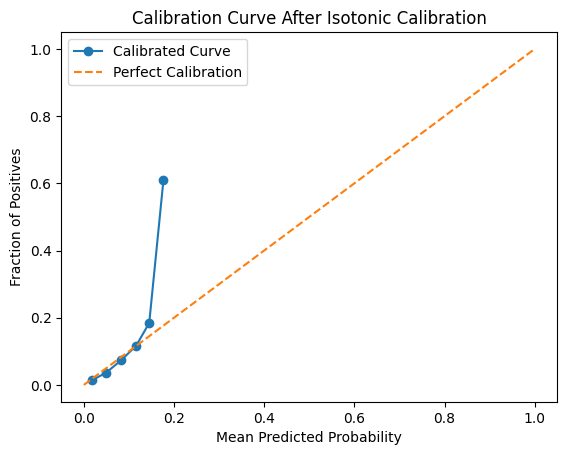

In [29]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap the existing model with calibration

calibrated_model = CalibratedClassifierCV(base_estimator=model)
calibrated_model.fit(X_train, y_train)

# Predict calibrated probabilities
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Plot the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=30)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve After Isotonic Calibration')
plt.show()


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, accuracy_score


# Predict calibrated probabilities
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

threshold = 0.1 
y_pred = (y_pred_proba_calibrated > threshold).astype(int)


# Evaluate the model
print(classification_report(y_test, y_pred))

# Evaluate the model acuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      5565
           1       0.15      0.67      0.24       422

    accuracy                           0.70      5987
   macro avg       0.56      0.69      0.53      5987
weighted avg       0.91      0.70      0.77      5987

Accuracy: 0.6985


In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, accuracy_score


# Predict calibrated probabilities
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Adjust the prediction threshold
threshold = 0.07 
y_pred = (y_pred_proba_calibrated > threshold).astype(int)


# Evaluate the model
print(classification_report(y_test, y_pred))

# Evaluate the model acuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

           0       0.95      0.81      0.88      5565
           1       0.15      0.45      0.23       422

    accuracy                           0.79      5987
   macro avg       0.55      0.63      0.55      5987
weighted avg       0.89      0.79      0.83      5987

Accuracy: 0.7855


In [68]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, precision_score, f1_score
from sklearn.impute import SimpleImputer
import pandas as pd
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import xgboost as xgb
imputer = SimpleImputer(strategy='median')
df2 = pd.DataFrame(imputer.fit_transform(processed_data), columns=processed_data.columns)

# Define parameter grid for LightGBM
param_grid = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.01, 0.1],  
    'num_leaves': [31, 50], 
    'max_depth': [-1, 10], 
    'reg_alpha': [1, 10], 
    'reg_lambda': [1, 10],  

}

param_xgb = {
    "objective": ["binary:logistic"],  
    "max_depth": [10, 20],       
    "scale_pos_weight": [10,50], 
    "eta": [0.01, 0.05],    
    "min_child_weight": [1, 3, 5],     
    "lambda": [ 1, 50],              
}


# Split the clients into train and test sets
clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]

# Define features and target
X_train = train_data.drop(columns=['credit_application', 'client_nr', 'yearmonth'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application', 'client_nr', 'yearmonth'])
y_test = test_data['credit_application']





# model = LGBMClassifier(
#     random_state=42,
#     class_weight='balanced'  
# )

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=[ 'logloss'],  
    scale_pos_weight=15,     
)

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_xgb,
    scoring='f1',  
    cv=3,
    verbose=1,
    n_jobs=-1  
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best F1 Score (CV): {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")

# Evaluate precision, recall, and F1-score on the test set
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"Test Precision: {precision}")
print(f"Test F1 Score: {f1}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [41]:
from sklearn.metrics import classification_report

y_pred = best_model.predict_proba(X_test)[:,1]
y_pred = (y_pred > 0.1).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.11      0.19      5522
         1.0       0.08      0.99      0.15       441

    accuracy                           0.17      5963
   macro avg       0.54      0.55      0.17      5963
weighted avg       0.92      0.17      0.19      5963



In [104]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# Split the training data into base and meta datasets
X_train_base, X_meta, y_train_base, y_meta = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize base models
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Train the base models
rf.fit(X_train_base, y_train_base)
lgbm.fit(X_train_base, y_train_base)

meta_features = np.column_stack([
    rf.predict_proba(X_meta)[:, 1],  
    lgbm.predict_proba(X_meta)[:, 1]
])

meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_features, y_meta)

# Generate meta-features for the test set
test_meta_features = np.column_stack([
    rf.predict_proba(X_test)[:, 1],  
    lgbm.predict_proba(X_test)[:, 1] 
])

# Make final predictions using the meta-model
final_predictions = meta_model.predict_proba(test_meta_features)[:, 1]

# Evaluate the performance of the stacked model
auc = roc_auc_score(y_test, final_predictions)
print(f"Stacked Model Test AUC: {auc}")


[LightGBM] [Info] Number of positive: 1264, number of negative: 17943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54892
[LightGBM] [Info] Number of data points in the train set: 19207, number of used features: 272
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Stacked Model Test AUC: 0.7372678768368655


In [106]:
final_predictions_binary = (final_predictions >= 0.2).astype(int)
print(f"Stacked Model Test AUC: {auc}")
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_predictions_binary, zero_division=1))


Stacked Model Test AUC: 0.7372678768368655

Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5565
           1       0.24      0.14      0.18       422

    accuracy                           0.91      5987
   macro avg       0.59      0.55      0.56      5987
weighted avg       0.89      0.91      0.90      5987



In [103]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# Split data for stacking
X_train_base, X_meta, y_train_base, y_meta = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train base models
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf.fit(X_train_base, y_train_base)
lgbm.fit(X_train_base, y_train_base)

# Generate meta-features
meta_features = np.column_stack([
    rf.predict_proba(X_meta)[:, 1],
    lgbm.predict_proba(X_meta)[:, 1]
])

# Train meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_features, y_meta)

# Final predictions
test_meta_features = np.column_stack([
    rf.predict_proba(X_test)[:, 1],
    lgbm.predict_proba(X_test)[:, 1]
])
final_predictions = meta_model.predict_proba(test_meta_features)[:, 1]

# Evaluate performance
auc = roc_auc_score(y_test, final_predictions)
print(f"Stacked Model Test AUC: {auc}")


final_predictions_binary = (final_predictions >= 0.5).astype(int)
print(f"Stacked Model Test AUC: {auc}")
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_predictions_binary, zero_division=1))



NameError: name 'X_train_resampled' is not defined

In [64]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

# Scaling features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split data for stacking
X_train_base, X_meta, y_train_base, y_meta = train_test_split(
    X_train_resampled_scaled, y_train, test_size=0.2, random_state=42
)

# Train base models
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_base[y_train_base == 0]) / len(y_train_base[y_train_base == 1]))
adaboost = AdaBoostClassifier(random_state=42)

rf.fit(X_train_base, y_train_base)
lgbm.fit(X_train_base, y_train_base)
xgb.fit(X_train_base, y_train_base)
adaboost.fit(X_train_base, y_train_base)

# Generate meta-features
meta_features = np.column_stack([
    rf.predict_proba(X_meta)[:, 1],
    lgbm.predict_proba(X_meta)[:, 1],
    xgb.predict_proba(X_meta)[:, 1],
    adaboost.predict_proba(X_meta)[:, 1],
])

# Train meta-model with L1 regularization
meta_model = LogisticRegression(random_state=42, penalty='l1', solver='liblinear', class_weight='balanced')
meta_model.fit(meta_features, y_meta)

# Final predictions (stacking)
test_meta_features = np.column_stack([
    rf.predict_proba(X_test_scaled)[:, 1],
    lgbm.predict_proba(X_test_scaled)[:, 1],
    xgb.predict_proba(X_test_scaled)[:, 1],
    adaboost.predict_proba(X_test_scaled)[:, 1],
])
final_predictions = meta_model.predict_proba(test_meta_features)[:, 1]

# Evaluate performance of stacked model
auc = roc_auc_score(y_test, final_predictions)
final_predictions_binary = (final_predictions >= 0.5).astype(int)
print(f"Stacked Model Test AUC: {auc}")
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_predictions_binary, zero_division=1))

# Soft voting ensemble
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('adaboost', adaboost),
    ],
    voting='soft',
    weights=[2, 3, 3, 1]  # Adjust weights based on performance
)

# Train the soft voting ensemble on the full resampled data
voting_ensemble.fit(X_train_resampled_scaled, y_train)

# Predict with the ensemble
voting_predictions = voting_ensemble.predict_proba(X_test_scaled)[:, 1]
voting_predictions_binary = (voting_predictions >= 0.5).astype(int)

# Evaluate the ensemble
voting_auc = roc_auc_score(y_test, voting_predictions)
print(f"\nSoft Voting Ensemble Test AUC: {voting_auc}")
print("\nClassification Report for Soft Voting Ensemble:")
print(classification_report(y_test, voting_predictions_binary, zero_division=1))


[LightGBM] [Info] Number of positive: 1264, number of negative: 17943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19796
[LightGBM] [Info] Number of data points in the train set: 19207, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Stacked Model Test AUC: 0.7148030812074451

Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      5565
           1       0.12      0.68      0.21       422

    accuracy                           0.63      5987
   macro avg       0.54      0.66      0.48      5987
weighted avg       0.90      0.63      0.72      5987

[LightGBM] [Info] Number of positive: 1603, number of negative: 22406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19794
[LightGBM] [Info] Number of data points in the train set: 24009, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Soft Voting Ensemble Test AU

In [68]:
final_predictions_binary = (final_predictions >= 0.6).astype(int)
print(f"Stacked Model Test AUC: {auc}")
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_predictions_binary, zero_division=1))

Stacked Model Test AUC: 0.7148030812074451

Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      5565
           1       0.14      0.47      0.21       422

    accuracy                           0.75      5987
   macro avg       0.54      0.62      0.53      5987
weighted avg       0.89      0.75      0.81      5987



In [83]:
X_train.isnull().sum().sum()

0

In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.losses import BinaryFocalCrossentropy


# Padding function to ensure all sequences have 32 observations
def pad_sequences(data, client_col, seq_col, target_col, max_len=32):
    padded_X, padded_y = [], []
    
    for client_id, group in data.groupby(client_col):
        seq_data = group.sort_values(seq_col).drop(columns=[client_col, seq_col, target_col]).values
        target_data = group.sort_values(seq_col)[target_col].values
        
        # Padding the sequence with zeros
        if len(seq_data) < max_len:
            pad_length = max_len - len(seq_data)
            seq_data = np.vstack([np.zeros((pad_length, seq_data.shape[1])), seq_data])
            target_data = np.concatenate([np.zeros(pad_length), target_data])
        else:
            seq_data = seq_data[-max_len:]
            target_data = target_data[-max_len:]
        
        padded_X.append(seq_data)
        padded_y.append(target_data)
    
    return np.array(padded_X, dtype=np.float32), np.array(padded_y, dtype=np.float32)


client_classes = processed_data.groupby("client_nr")["credit_application"].max().reset_index()
client_classes["has_class_1"] = (client_classes["credit_application"] == 1).astype(int)

# Split client numbers into stratified train and test sets
train_clients, test_clients = train_test_split(
    client_classes["client_nr"],
    test_size=0.2,
    random_state=42,
    stratify=client_classes["has_class_1"] 
)

# Filter processed_data for train and test sets
train_data = processed_data[processed_data["client_nr"].isin(train_clients)]
test_data = processed_data[processed_data["client_nr"].isin(test_clients)]

# Convert 2D data into 3D for train and test sets
X_train, y_train = pad_sequences(
    train_data,
    client_col="client_nr",
    seq_col="yearmonth",
    target_col="credit_application",
    max_len=32
)
X_test, y_test = pad_sequences(
    test_data,
    client_col="client_nr",
    seq_col="yearmonth",
    target_col="credit_application",
    max_len=32
)

y_train = y_train.reshape(-1, 32, 1)
y_test = y_test.reshape(-1, 32, 1)


# Build the LSTM model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(32, X_train.shape[2])),
    LSTM(64, return_sequences=True),  
    Dense(1, activation="sigmoid")   
])



model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryFocalCrossentropy(alpha=100), 
    metrics=["accuracy"]
)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8648 - loss: 0.1008 - val_accuracy: 0.9265 - val_loss: 0.0894
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9295 - loss: 0.0750 - val_accuracy: 0.9332 - val_loss: 0.0823
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9330 - loss: 0.0720 - val_accuracy: 0.9353 - val_loss: 0.0794
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9357 - loss: 0.0685 - val_accuracy: 0.9357 - val_loss: 0.0775
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9355 - loss: 0.0674 - val_accuracy: 0.9363 - val_loss: 0.0763
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9390 - loss: 0.0657 - val_accuracy: 0.9367 - val_loss: 0.0755
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9365 - loss: 0.0660 - val_accuracy: 0.9375 - val_loss: 0.0754
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9353 - loss: 0.0670 - val_accuracy: 0.9373 - val_loss: 0.

In [38]:

predictions = model.predict(X_test)  # Shape: (num_sequences, 32, 1)

y_test_flat = y_test.reshape(-1)
predictions_flat = predictions.reshape(-1)

y_pred_proba = predictions_flat

y_pred = (y_pred_proba >= 0.3).astype(int)

# Generate classification report
report = classification_report(y_test_flat, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)

# Calculate and display AUC-ROC score
auc_score = roc_auc_score(y_test_flat, y_pred_proba)
print(f"AUC-ROC Score: {auc_score}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.75      0.84      5959
     Class 1       0.09      0.35      0.14       409

    accuracy                           0.73      6368
   macro avg       0.52      0.55      0.49      6368
weighted avg       0.89      0.73      0.79      6368

AUC-ROC Score: 0.6101093823277317


In [15]:
#if we wan to apply pca and random forrest

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]


X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for compatibility with column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


# Original model
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Performance with original features:")
print(classification_report(y_test, y_pred))

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Model with PCA-transformed features
model_pca = RandomForestClassifier(random_state=42, class_weight='balanced')
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
print("Performance with PCA features:")
print(classification_report(y_test, y_pred_pca))


Performance with original features:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5522
           1       0.00      0.00      0.00       441

    accuracy                           0.93      5963
   macro avg       0.46      0.50      0.48      5963
weighted avg       0.86      0.93      0.89      5963



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Performance with PCA features:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5522
           1       0.00      0.00      0.00       441

    accuracy                           0.93      5963
   macro avg       0.46      0.50      0.48      5963
weighted avg       0.86      0.93      0.89      5963



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [ ]:
# Pivot the data to make it columnar
def pivot_to_columnar(df, target_yearmonth):
    df_pivoted = df.pivot(index='client_nr', columns='yearmonth', values=[
         'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx',
        'volume_credit_trx', 'min_balance', 'max_balance', 'credit_application'
    ])

    # Flatten the multi-level columns
    df_pivoted.columns = ['{}_{}'.format(col[0], col[1]) for col in df_pivoted.columns]
    
    # Reset index
    df_pivoted.reset_index(inplace=True)

    # Ensure all yearmonths are included
    for col_prefix in [ 'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx', 
                       'volume_credit_trx', 'min_balance', 'max_balance', 'credit_application']:
        for yearmonth in range(df['yearmonth'].min(), target_yearmonth + 1):
            col_name = f"{col_prefix}_{yearmonth}"
            if col_name not in df_pivoted:
                df_pivoted[col_name] = 0

    # Create the target column
    df_pivoted['credit_application_target'] = df_pivoted[f'credit_application_{target_yearmonth}']

    # Drop future columns after target
    df_pivoted = df_pivoted[df_pivoted.columns[~df_pivoted.columns.str.endswith(str(target_yearmonth))]]

    return df_pivoted

# Specify the target yearmonth
target_yearmonth = 201608

# Transform the data
transformed_df = pivot_to_columnar(df, target_yearmonth)


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_2929/2531957398.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivoted[col_name] = 0
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_2929/2531957398.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivoted[col_name] = 0
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_2929/2531957398.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [27]:
transformed_df.head()

,client_nr,nr_debit_trx_201401,nr_debit_trx_201402,nr_debit_trx_201403,nr_debit_trx_201404,nr_debit_trx_201405,nr_debit_trx_201406,nr_debit_trx_201407,nr_debit_trx_201408,nr_debit_trx_201409,...,credit_application_201592,credit_application_201593,credit_application_201594,credit_application_201595,credit_application_201596,credit_application_201597,credit_application_201598,credit_application_201599,credit_application_201600,credit_application_target
0,1,50.0,59.0,62.0,53.0,54.0,51.0,59.0,40.0,49.0,...,0,0,0,0,0,0,0,0,0,0.0
1,2,51.0,47.0,45.0,47.0,32.0,45.0,52.0,46.0,43.0,...,0,0,0,0,0,0,0,0,0,0.0
2,3,58.0,63.0,62.0,76.0,52.0,71.0,80.0,72.0,56.0,...,0,0,0,0,0,0,0,0,0,1.0
3,4,29.0,31.0,32.0,28.0,25.0,29.0,32.0,22.0,29.0,...,0,0,0,0,0,0,0,0,0,0.0
4,5,71.0,61.0,75.0,72.0,32.0,84.0,103.0,68.0,92.0,...,0,0,0,0,0,0,0,0,0,0.0


In [31]:
transformed_df.fillna(0, inplace=True)


In [34]:
from imblearn.under_sampling import RandomUnderSampler
clients = transformed_df['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = transformed_df[transformed_df['client_nr'].isin(train_clients)]
test_data = transformed_df[transformed_df['client_nr'].isin(test_clients)]


X_train = train_data.drop(columns=['credit_application_target'])
y_train = train_data['credit_application_target']

X_test = test_data.drop(columns=['credit_application_target'])
y_test = test_data['credit_application_target']

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

)



grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [70]:
from sklearn.ensemble import IsolationForest

df5 = df_imputed.copy()
df5 = df5.drop(['credit_application'], axis=1)

In [71]:
model=IsolationForest(n_estimators=150, max_samples='auto')
model.fit(df5)

IsolationForest(n_estimators=150)

In [72]:
scores=model.decision_function(df5)
anomaly=model.predict(df5)

df5['scores']=scores
df5['anomaly']=anomaly

df5.head(10)

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,scores,anomaly
0,1.0,201401.0,97.0,50.0,6527929.0,47.0,7454863.0,-7914288.0,25110651.0,1.0,0.038950,1
1,1.0,201402.0,88.0,59.0,3475918.0,29.0,1895848.0,-8448513.0,25036651.0,1.0,0.030369,1
2,1.0,201403.0,96.0,62.0,31316405.0,34.0,20083583.0,-10347650.0,18020151.0,1.0,0.018865,1
3,1.0,201404.0,83.0,53.0,18669967.0,30.0,1091295.0,-15385039.0,13318200.0,1.0,0.017038,1
4,1.0,201405.0,94.0,54.0,2893905.0,40.0,2034075.0,-15682170.0,2350000.0,1.0,0.045369,1
5,1.0,201406.0,74.0,51.0,2083142.0,23.0,3241073.0,-15927514.0,2000000.0,1.0,0.042979,1
6,1.0,201407.0,76.0,59.0,2538771.0,17.0,4564281.0,-15823639.0,2005161.0,1.0,0.047610,1
7,1.0,201408.0,62.0,40.0,2620143.0,22.0,4280647.0,-14468191.0,1750000.0,1.0,0.049347,1
8,1.0,201409.0,90.0,49.0,2500177.0,41.0,8339304.0,-12025540.0,1600000.0,1.0,0.057489,1
9,1.0,201410.0,112.0,68.0,5848714.0,44.0,17013661.0,-7211508.0,7819451.0,1.0,0.056284,1


In [73]:

anomaly = df5.loc[df5['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

Total number of outliers is: 3483


In [85]:
df_imputed.client_nr.value_counts()

client_nr
1.0      32
618.0    32
606.0    32
607.0    32
608.0    32
         ..
996.0     2
971.0     1
377.0     1
256.0     1
433.0     1
Name: count, Length: 992, dtype: int64

120


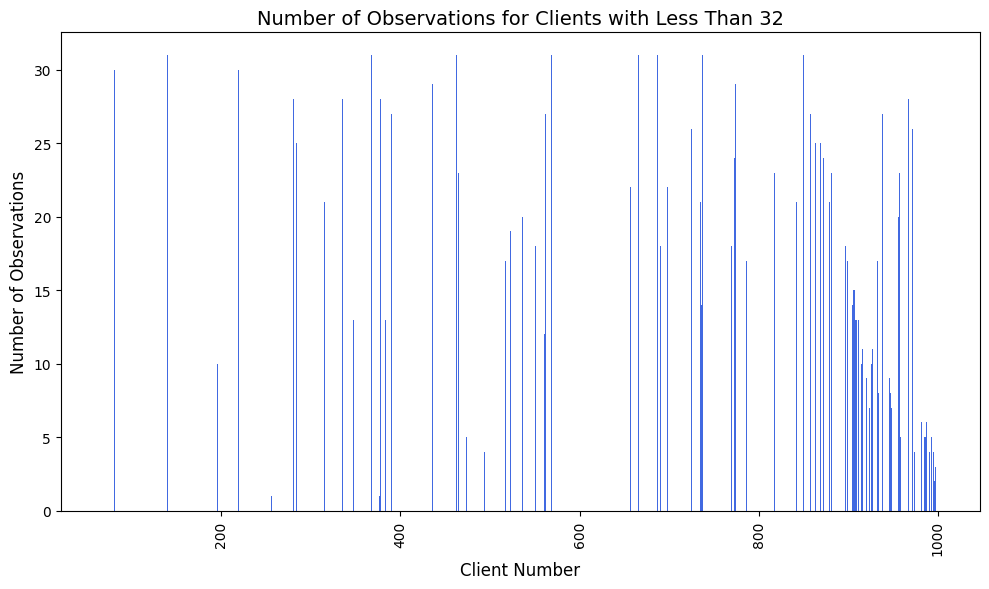

In [97]:
observation_counts = df_imputed['client_nr'].value_counts().reset_index()
observation_counts.columns = ['client_number', 'num_observations']

# Filter clients with less than 32 observations
filtered_df = observation_counts[observation_counts['num_observations'] < 32]
print(filtered_df.client_number.nunique())
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['client_number'], filtered_df['num_observations'])

# Customize the plot
plt.xlabel('Client Number', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)
plt.title('Number of Observations for Clients with Less Than 32', fontsize=14)
plt.xticks(rotation=90, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [82]:
# attach back  the target variable credit_application
df5['credit_application'] = df_imputed['credit_application']


In [83]:
df5[(df5['anomaly']==-1) & (df5['credit_application']==1)]

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,scores,anomaly,credit_application
70,3.0,201407.0,138.0,80.0,16424314.0,58.0,18660918.0,-50657408.0,-43590640.0,4.0,-0.040753,-1,1.0
81,3.0,201506.0,119.0,62.0,20268645.0,57.0,18085849.0,-50869752.0,-37022602.0,4.0,-0.040421,-1,1.0
87,3.0,201512.0,113.0,63.0,20967265.0,50.0,16562411.0,-50236785.0,-39779240.0,4.0,-0.040767,-1,1.0
95,3.0,201608.0,117.0,58.0,13198950.0,59.0,13238229.0,-54288785.0,-49699301.0,4.0,-0.055190,-1,1.0
172,6.0,201501.0,182.0,129.0,14650103.0,53.0,16878672.0,-29319663.0,3579881.0,7.0,-0.011536,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29576,975.0,201401.0,280.0,167.0,64473466.0,113.0,63621465.0,-37051268.0,26908185.0,2.0,-0.118655,-1,1.0
29600,975.0,201601.0,229.0,176.0,31322896.0,53.0,24106890.0,-10626213.0,12076283.0,2.0,-0.013776,-1,1.0
29603,975.0,201604.0,270.0,201.0,24172463.0,69.0,23094210.0,-12873012.0,3908083.0,2.0,-0.005055,-1,1.0
29702,979.0,201607.0,6.0,6.0,176851.0,0.0,0.0,-5683734.0,-5621237.0,7.0,-0.008323,-1,1.0


In [100]:
import pandas as pd
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np
import matplotlib.pyplot as plt



# Reshape data into a time-series format (pivot table)
time_series_data = df.pivot(index='client_nr', columns='yearmonth', values='credit_application').fillna(0).values

# Scale the data for K-Shape clustering
scaler = TimeSeriesScalerMeanVariance()
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Apply K-Shape clustering
kshape = KShape(n_clusters=3, random_state=42)
clusters_kshape = kshape.fit_predict(time_series_data_scaled)

# Add cluster labels back to the data
df_kshape = pd.DataFrame({'client_nr': df['client_nr'].unique(), 'cluster': clusters_kshape})
print("K-Shape Clustering Results:")
print(df_kshape)





K-Shape Clustering Results:
     client_nr  cluster
0            1        0
1            2        0
2            3        2
3            4        2
4            5        0
..         ...      ...
987        996        0
988        997        0
989        998        0
990        999        0
991       1000        0

[992 rows x 2 columns]


In [32]:
from scipy import stats

df[stats.zscore(df['total_nr_trx'])>3]['total_nr_trx'].count()


np.int64(271)

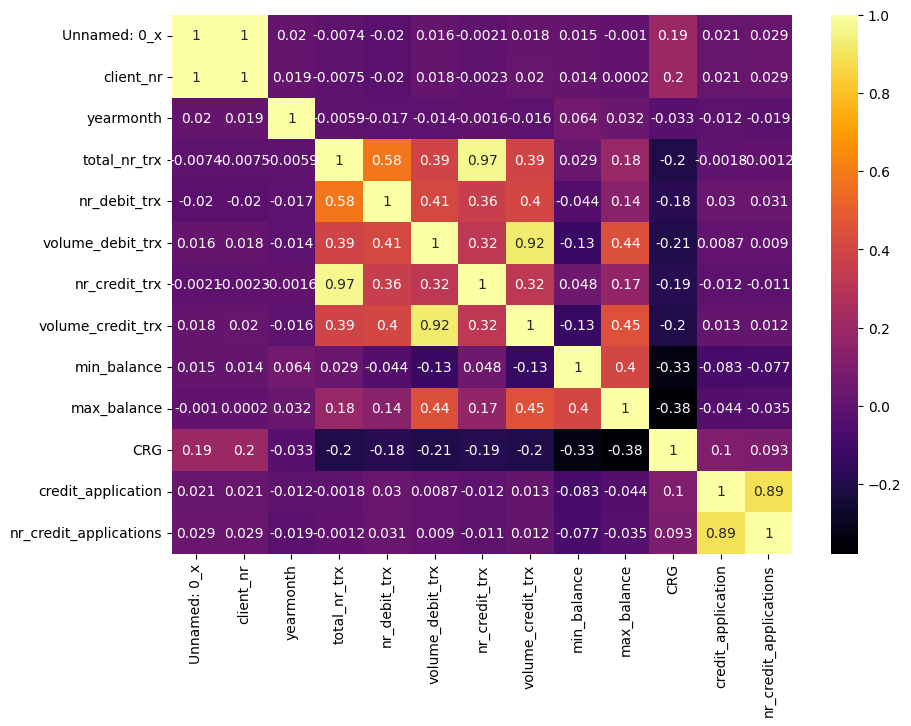

In [33]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='inferno');